In [ ]:
from google.colab import drive
drive.mount('content')

Mounted at content


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import polars as pl
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error
import pickle, time, logging, glob, pathlib, random
from sklearn.metrics import r2_score
import torch, math
from torch.utils.data import  Dataset, DataLoader
from functools import lru_cache
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn

root = pathlib.Path(f"/content/content/MyDrive/Kaggle Competitions/Jane Street/train.npy")
def get_paths(nums: list) -> list:
    return [root/f"symbol={i}/window=4/part-0.npz" for i in nums]

train_paths = get_paths(range(36))
val_paths = get_paths(range(36,38))
final_path = get_paths([38])

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
cfg = {
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "window": 4,
    "batch_size":96,
    "shuffle":False,
    "dim": np.load(train_paths[0], allow_pickle=True)["data"].shape[-1],
    "drop_last":True,
    "num_workers":1,
    "frac": None,
    "pin_memory": True,
    "prefetch_factor":2,
    "persistent_workers":True
}

In [ ]:
cfg

{'device': device(type='cpu'),
 'window': 4,
 'batch_size': 96,
 'shuffle': False,
 'dim': 46,
 'drop_last': True,
 'num_workers': 1,
 'frac': None,
 'pin_memory': True,
 'prefetch_factor': 2,
 'persistent_workers': True}

In [ ]:
class JaneStreetDatasetV1(Dataset):
    def __init__(self, paths, cfg):
        self.file_mappings = []
        self.total_rows = 0
        self.frac = cfg["frac"]


        for path in tqdm(paths, desc="Processing financial instruments"):
            data = np.load(path,allow_pickle=True)["target"]
            size = int(data.shape[0] * self.frac) if self.frac else data.shape[0]
            self.file_mappings.append((path, self.total_rows, self.total_rows + size)) # Map cumulative row count to file path
            self.total_rows += size


    @lru_cache(maxsize = 10)
    def load_file(self, path_name):
        train_npy = np.load(path_name, allow_pickle=True, mmap_mode="r")
        return train_npy["data"], train_npy["target"]

    def __len__(self):
        return self.total_rows

    def __getitem__(self, idx):
        for path, offset, sum_k in self.file_mappings:
            if idx < sum_k:
                size = idx - offset
                data, targets = self.load_file(path)
                return (
                    torch.tensor(data[size], dtype=torch.float32),
                    torch.tensor(targets[size], dtype=torch.float32).unsqueeze(0)
                )

In [ ]:
def create_dataloader_v1(paths, cfg):
    dataset = JaneStreetDatasetV1(paths, cfg)
    dataloader = DataLoader(dataset=dataset,
                            batch_size=cfg["batch_size"],
                            shuffle=cfg["shuffle"],
                            drop_last=cfg["drop_last"],
                            num_workers=cfg["num_workers"]
                           )

    return dataloader

In [ ]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
      torch.nn.init.xavier_uniform_(m.weight) #torch.nn.init.normal_(m.weight, mean=0.0, std=1/math.sqrt(6))
      if m.bias is not None:
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, torch.nn.Embedding):
        torch.nn.init.xavier_uniform_(m.weight) #torch.nn.init.normal_(m.weight, mean=0.0, std=1/math.sqrt(6))

class MultiHeadMaskAttention(torch.nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, window, bias, num_layers):
        super().__init__()
        self.num_heads = num_heads
        self.qk_scale = 1/math.sqrt(6)
        self.pos_emb = torch.nn.Embedding(window, dim_in)
        self.W_query = torch.nn.Linear(dim_in, dim_out*num_heads, bias=bias)
        self.W_key = torch.nn.Linear(dim_in, dim_out*num_heads, bias=bias)
        self.W_value = torch.nn.Linear(dim_in, dim_out*num_heads, bias=bias)
        self.out_proj = torch.nn.Linear(dim_out, dim_out)
        self.softmax = torch.nn.Softmax(dim=-1)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(window,window), diagonal=1).bool()
        )

    def forward(self, inp):
        batch, window, emb = inp.shape
        pos_emb = self.pos_emb(torch.arange(window, device=inp.device))

        queries = self.W_query(inp) / self.qk_scale
        keys = self.W_key(inp) / self.qk_scale
        values = self.W_value(inp)

        keys = keys.view(batch, window, self.num_heads, emb)
        queries = queries.view(batch, window, self.num_heads, emb)
        values = values.view(batch, window, self.num_heads, emb)

        keys = keys.transpose(1,2)
        queries = queries.transpose(1,2)
        values = values.transpose(1,2) + pos_emb

        attn_scores = queries @ keys.mT
        attn_scores = attn_scores.masked_fill(self.mask, -torch.inf)
        attn_weights = self.softmax(attn_scores / keys.shape[-1]**0.5)
        context_vectors = (attn_weights @ values).transpose(1,2).mean(dim=-2)
        return self.out_proj(context_vectors)/0.01

class LayerNorm(torch.nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.eps = 1e-5
        self.shift = torch.nn.Parameter(torch.zeros(dim))
        self.scale = torch.nn.Parameter(torch.ones(dim))

    def forward(self, inp):
        mean = inp.mean(dim=-1, keepdim=True)
        var = inp.var(dim=-1, keepdim=True, unbiased=False)
        inp_norm = (inp - mean)/(torch.sqrt(var)+self.eps)

        return inp_norm + self.shift * self.scale

class FeedForwardLayer(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(cfg["n_features"], cfg["n_features"] * cfg["window"]),
            torch.nn.LeakyReLU(), #torch.nn.GELU(approximate="tanh"),
            torch.nn.Linear(cfg["n_features"] * cfg["window"], cfg["n_features"]),
        )


    def forward(self, inp):
        return self.layer(inp)

class TransformerBlock(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.attention = MultiHeadMaskAttention(dim_in=cfg["n_features"], dim_out=cfg["n_features"], num_heads=cfg["num_heads"],
                                                window=cfg["window"], bias=cfg["qkv_bias"], num_layers=cfg["n_layers"])
        self.forward_layer = FeedForwardLayer(cfg)
        self.norm1 = LayerNorm(cfg["n_features"])
        self.norm2 = LayerNorm(cfg["n_features"])
        self.dropout = torch.nn.Dropout(cfg["drop_rate"])

    def forward(self, inp):
        shortcut = inp
        inp = self.norm1(inp)
        inp = self.attention(inp)
        inp = inp + shortcut

        shortcut = inp
        inp = self.norm2(inp)
        inp = self.forward_layer(inp)
        out = self.dropout(inp)
        return out + shortcut

In [ ]:
class JaneStreetModelV1(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.blocks = torch.nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.norm =  LayerNorm(cfg["n_features"])
        self.final_norm = LayerNorm(cfg["n_features"])
        self.out_proj = torch.nn.Linear(cfg["n_features"], 1, bias=False)

    def forward(self, inp):
        inp = self.blocks(self.norm(inp))
        inp = inp.mean(dim=1)/0.1
        inp = self.final_norm(inp)

        return self.out_proj(inp)

In [ ]:
MODEL_CONFIG = {
    "n_features": cfg["dim"],
    "window": cfg["window"],
    "num_heads": 3,
    "n_layers": 3,
    "drop_rate": 0.05,
    "qkv_bias": False
}

In [ ]:
def calc_loss_batch(inp, targets, device):
    inp = inp.to(device)
    targets = targets.to(device)
    outputs = model(inp)
    loss = torch.nn.functional.l1_loss(outputs, targets)

    return loss.item(), outputs

def evaluate_model(val_loader, num_batch, device, choices):
    total_loss = 0
    for i, (inp, targets) in enumerate(val_loader):
        if i < num_batch:
            with torch.no_grad():
                loss, outputs = calc_loss_batch(
                    inp=inp, targets=targets, device=device
                )
            total_loss += loss
        else:
            break
    outputs = outputs.flatten().detach().cpu().numpy()
    targets = targets.flatten().detach().cpu().numpy()
    print(f"Sample predictions range: (max:{max(outputs)}, min:{min(outputs)}) - Targets range: (max:{max(targets)}, min:{min(targets)})")
    return total_loss/num_batch

def train_epoch(train_loader, device, freq, choices, global_step,
                half_loops, start_lr, min_lr):
    last_loss, running_loss = 0., 0.
    time_step = 0.
    scores = []
    total_len = len(train_loader)

    for batch, (input_batch, targets_batch) in enumerate(train_loader):
        #compute time per step
        start_time = time.time()
        #transfer data to device
        input_batch = input_batch.to(device)
        targets_batch = targets_batch.to(device)
        #zero gradients for every batch
        optimizer.zero_grad()
        global_step += 1
        if global_step <= half_loops:
            # Apply cosine decay to halfway point
            optimizer.param_groups[0]["lr"] = min_lr + 0.5 * (start_lr - min_lr) * (1 + math.cos(math.pi * global_step / half_loops))
        else:
            # Maintain the minimum learning rate beyond halfway point
            optimizer.param_groups[0]["lr"] = min_lr
        outputs = model(input_batch)
        loss = torch.nn.functional.smooth_l1_loss(outputs, targets_batch)
        loss.backward()
        optimizer.step()
        time_step += time.time() - start_time

        running_loss += loss.item()
        if batch % freq == freq-1:
            last_loss = running_loss / freq
            print(f"Batch {batch}/{total_len} - {time_step/freq:.3f}s/step - loss: {last_loss} - lr: {optimizer.param_groups[0]['lr']}")
            # print(f"Model prediction: {outputs[choices].flatten().detach().cpu().numpy()} - Target: {targets_batch[choices].flatten().cpu().numpy()} ")
            running_loss = 0.
            time_step = 0.
            scores.append(last_loss)

    return np.mean(scores), global_step

def train_model(epochs, train_loader, freq, device, frac=4, min_lr=5e-4, num_batch=None, val_loader=None):

    global_step = -1
    total_loops = len(train_loader) * epochs
    half_loops = total_loops // frac
    start_lr = optimizer.param_groups[0]["lr"]
    history = {"loss": []}

    choices = random.choices(range(cfg["batch_size"]-10),k=3)
    for i in range(epochs):
        print(f"Epoch {i+1}/{epochs}")
        #set model to training mode
        model.train(True)
        #train model
        avg_loss, global_step = train_epoch(
            train_loader=train_loader, device=device, freq=freq, choices=choices,
            global_step=global_step, half_loops=half_loops, start_lr=start_lr, min_lr=min_lr
        )

        if val_loader:
            model.eval()
            avg_vloss = evaluate_model(
                val_loader=val_loader, num_batch=num_batch, choices=choices, device=device
            )
            history["val_loss"] = history.get('val_loss', []) + [avg_vloss]
            print(f"train loss: {avg_loss} - val loss: {avg_vloss}")
        else:
            print(f"train loss: {avg_loss}")
        history["loss"].append(avg_loss)

    return history

In [ ]:
cfg["frac"] = 0.08
folds = 5
kfold = KFold(n_splits=folds, random_state=123, shuffle=True)
paths = np.array(train_paths[:7])
historys = {"val_loss": [], "loss": [], "val_score":[], "score":[]}
for train_path, test_path in kfold.split(paths):
    train = create_dataloader_v1(paths[train_path], cfg)
    test = create_dataloader_v1(paths[test_path], cfg)

    torch.manual_seed(11) #11 #32
    model = JaneStreetModelV1(MODEL_CONFIG)
    # model.apply(init_weights)
    model.to(cfg["device"])
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=5e-3, weight_decay=1e-4
    )
    num_epochs = 5
    history = train_model(epochs=num_epochs, train_loader=train, val_loader=test, frac=1, freq=len(train)//2, min_lr=3e-4,
                          num_batch=len(test), device=cfg["device"])

    print(f'Epochs({num_epochs}): Train error: {np.mean(history["loss"]):.7f} - Validation Error: {np.mean(history["val_loss"]):.7f}')
    print()
    historys["val_score"].append(history["val_loss"][-1])
    historys["score"].append(history["loss"][-1])
    historys["val_loss"].append(history["val_loss"])
    historys["loss"].append(history["loss"])

print(f"""KFold Cross Validation: {folds} - Mean Train error: {np.mean(historys["score"]):.7f} - Mean Validation error: {np.mean(historys["val_score"]):.7f}""")

Processing financial instruments: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Epoch 1/5
Batch 2209/4421 - 0.035s/step - loss: 0.2545481935946262 - lr: 0.00488513757315797
Batch 4419/4421 - 0.036s/step - loss: 0.38147347425932393 - lr: 0.004551582483117778
Sample predictions range: (max:-0.00341998552903533, min:-0.006085380911827087) - Targets range: (max:1.2034406661987305, min:-1.0122123956680298)
train loss: 0.31801083392697505 - val loss: 0.5340727542857393
Epoch 2/5
Batch 2209/4421 - 0.035s/step - loss: 0.2506855375348375 - lr: 0.004031700611044629
Batch 4419/4421 - 0.037s/step - loss: 0.3814535473469156 - lr: 0.0033768251850288464
Sample predictions range: (max:-0.007286215666681528, min:-0.008221397176384926) - Targets range: (max:1.2034406661987305, min:-1.0122123956680298)
train loss: 0.3160695424408766 - val loss: 0.5339539300494889
Epoch 3/5
Batch 2209/4421 - 0.035s/step - loss: 0.25057738341846214 - lr: 0.002650500977788737
Batch 4419/4421 - 0.037s/step - loss: 0.3813405615264946 - lr: 0.001924445370138327
Sample predictions range: (max:-0.0137973185

Processing financial instruments: 100%|██████████| 2/2 [00:00<00:00, 13.51it/s]

Epoch 1/5


Batch 2558/5119 - 0.038s/step - loss: 0.2559424183100692 - lr: 0.00488511647689525
Batch 5117/5119 - 0.036s/step - loss: 0.3366503575909555 - lr: 0.004551528966603078
Sample predictions range: (max:-0.006639842409640551, min:-0.010103779844939709) - Targets range: (max:1.5578693151474, min:-4.6940083503723145)
train loss: 0.2962963879505124 - val loss: 0.5806525873983298
Epoch 2/5
Batch 2558/5119 - 0.037s/step - loss: 0.25307040393586155 - lr: 0.004031645354500546
Batch 5117/5119 - 0.036s/step - loss: 0.3365946966227058 - lr: 0.0033767385693650605
Sample predictions range: (max:0.00089742720592767, min:-0.0007873655995354056) - Targets range: (max:1.5578693151474, min:-4.6940083503723145)
train loss: 0.2948325502792837 - val loss: 0.5809542647309963
Epoch 3/5
Batch 2558/5119 - 0.036s/step - loss: 0.25301727171839533 - lr: 0.0026504326670850303
Batch 5117/5119 - 0.039s/step - loss: 0.3362157031489393 - lr: 0.0019243587395650623
Sample predictions range: (max:-0.011556566692888737, min:-

Processing financial instruments: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]

Epoch 1/5


Batch 2837/5676 - 0.037s/step - loss: 0.22417045235200678 - lr: 0.004885063186949006
Batch 5675/5676 - 0.039s/step - loss: 0.36122365075460855 - lr: 0.004551342830956885
Sample predictions range: (max:-0.008484546095132828, min:-0.010225275531411171) - Targets range: (max:0.8303977847099304, min:-0.7144448757171631)
train loss: 0.29269705155330766 - val loss: 0.606285085883534
Epoch 2/5
Batch 2837/5676 - 0.036s/step - loss: 0.22112427730558912 - lr: 0.004031505791236233
Batch 5675/5676 - 0.041s/step - loss: 0.36370811583224877 - lr: 0.0033764373391525376
Sample predictions range: (max:0.00876784697175026, min:0.002491069259122014) - Targets range: (max:0.8303977847099304, min:-0.7144448757171631)
train loss: 0.29241619656891893 - val loss: 0.6072362927074957
Epoch 3/5
Batch 2837/5676 - 0.039s/step - loss: 0.22095738487548527 - lr: 0.002650260138926035
Batch 5675/5676 - 0.042s/step - loss: 0.3611097828136564 - lr: 0.0019240574744889567
Sample predictions range: (max:-0.01483394764363765

Processing financial instruments: 100%|██████████| 1/1 [00:00<00:00, 14.73it/s]

Epoch 1/5


Batch 3015/6032 - 0.036s/step - loss: 0.2312524796246467 - lr: 0.004885058444171489
Batch 6031/6032 - 0.037s/step - loss: 0.3474502969889553 - lr: 0.004551333808008568
Sample predictions range: (max:-0.007993243634700775, min:-0.009339410811662674) - Targets range: (max:1.450810432434082, min:-0.8637974858283997)
train loss: 0.289351388306801 - val loss: 0.6319116662075652
Epoch 2/5
Batch 3015/6032 - 0.037s/step - loss: 0.22833862914120165 - lr: 0.004031493371346167
Batch 6031/6032 - 0.038s/step - loss: 0.34738532726224314 - lr: 0.0033764227380660965
Sample predictions range: (max:-0.002404403407126665, min:-0.002631224226206541) - Targets range: (max:1.450810432434082, min:-0.8637974858283997)
train loss: 0.2878619782017224 - val loss: 0.6323774733351254
Epoch 3/5
Batch 3015/6032 - 0.035s/step - loss: 0.22829289943942013 - lr: 0.0026502447858992896
Batch 6031/6032 - 0.043s/step - loss: 0.3473515155517054 - lr: 0.001924042872383137
Sample predictions range: (max:-0.003308307845145464, 

Processing financial instruments: 100%|██████████| 1/1 [00:00<00:00, 24.63it/s]

Epoch 1/5


Batch 3200/6403 - 0.037s/step - loss: 0.2331970735023631 - lr: 0.004885089679272566
Batch 6401/6403 - 0.037s/step - loss: 0.3348811641897016 - lr: 0.004551460989798385
Sample predictions range: (max:3.6458688555285335e-05, min:-1.14112608571304e-05) - Targets range: (max:3.601442337036133, min:-1.8865545988082886)
train loss: 0.28403911884603233 - val loss: 0.761033482893511
Epoch 2/5
Batch 3200/6403 - 0.036s/step - loss: 0.23044301495517544 - lr: 0.0040315751700752064
Batch 6401/6403 - 0.037s/step - loss: 0.33465669590104646 - lr: 0.003376628555033307
Sample predictions range: (max:-0.0020819923374801874, min:-0.002214689739048481) - Targets range: (max:3.601442337036133, min:-1.8865545988082886)
train loss: 0.28254985542811095 - val loss: 0.7609244714141594
Epoch 3/5
Batch 3200/6403 - 0.037s/step - loss: 0.23039532989765127 - lr: 0.002650345903922034
Batch 6401/6403 - 0.039s/step - loss: 0.3345287607113404 - lr: 0.0019242487094417293
Sample predictions range: (max:-0.0016351587837561

In [ ]:
MODEL_CONFIG

{'n_features': 46,
 'window': 4,
 'num_heads': 3,
 'n_layers': 3,
 'drop_rate': 0.05,
 'qkv_bias': False}

In [ ]:
def log_gradients(model):
    for name, param in model.named_parameters():
        if param.grad is not None and "weight" in name:
            print(f"{name}: grad_mean={param.grad.mean().item()}, grad_std={param.grad.std().item()}")

log_gradients(model)

blocks.0.attention.pos_emb.weight: grad_mean=-8.265970791399013e-06, grad_std=0.0001389835524605587
blocks.0.attention.W_query.weight: grad_mean=-2.3790528658196308e-08, grad_std=1.7131170579887112e-06
blocks.0.attention.W_key.weight: grad_mean=-1.014370269096336e-13, grad_std=1.5595928744005505e-06
blocks.0.attention.W_value.weight: grad_mean=-6.68343943743821e-07, grad_std=0.00013701216084882617
blocks.0.attention.out_proj.weight: grad_mean=4.401335524338579e-13, grad_std=0.00014564768935088068
blocks.0.forward_layer.layer.0.weight: grad_mean=-4.199257386261479e-09, grad_std=6.109228252171306e-07
blocks.0.forward_layer.layer.2.weight: grad_mean=-1.8699913145736602e-11, grad_std=7.4220054102625e-07
blocks.1.attention.pos_emb.weight: grad_mean=-1.0443160363138304e-06, grad_std=2.4589877284597605e-05
blocks.1.attention.W_query.weight: grad_mean=-3.2039128294858443e-11, grad_std=1.324795988466576e-07
blocks.1.attention.W_key.weight: grad_mean=3.7376250369442615e-14, grad_std=2.8822307740

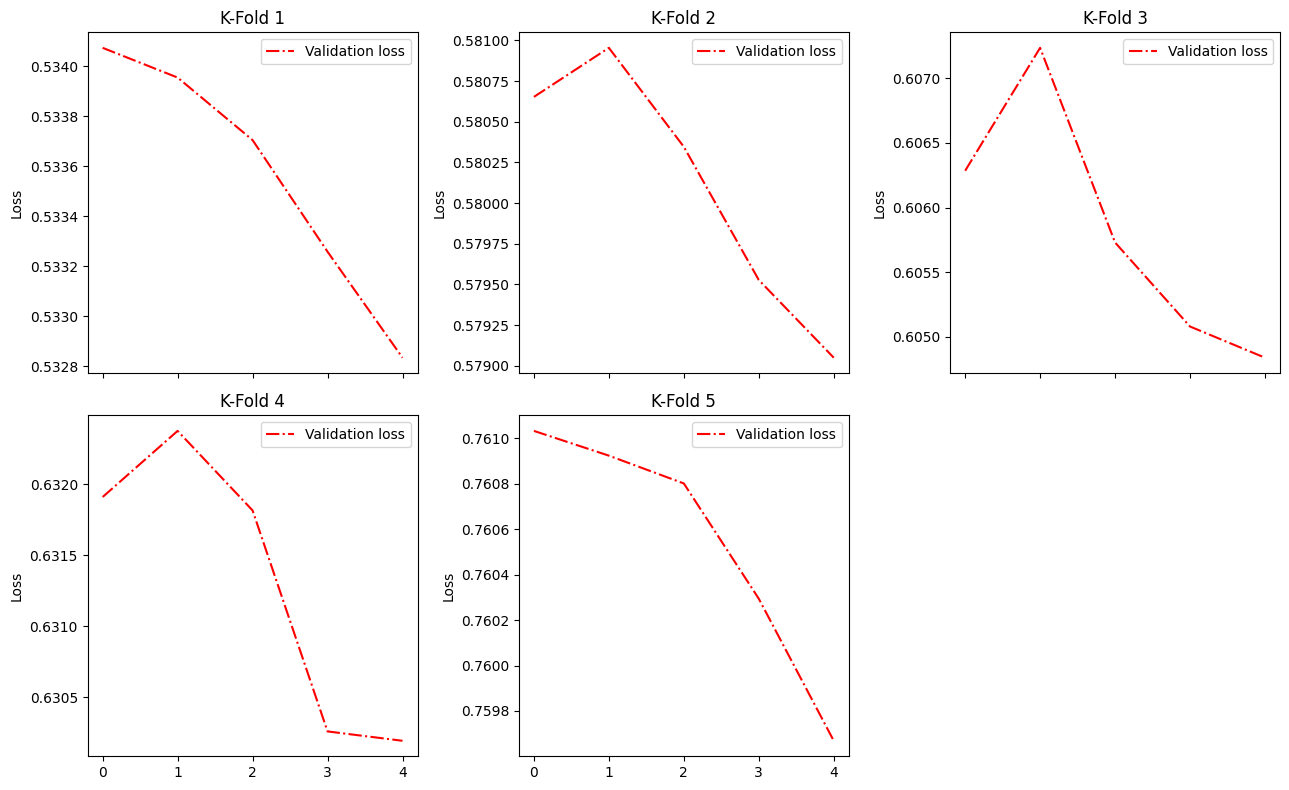

In [ ]:
def plot_losses(epochs, train_loss, val_loss):
    plots = len(train_loss)  # Number of distinct plots
    rows, cols = 2, 3  # Define grid dimensions (2 rows, 3 columns)

    fig, axes = plt.subplots(figsize=(13, 8), nrows=rows, ncols=cols, sharex=True)
    axes = axes.flatten()  # Flatten the axes array for easier indexing
    for i in range(plots):
        # axes[i].plot(range(epochs), train_loss[i], label="Training loss", c="b")
        axes[i].plot(range(epochs), val_loss[i], linestyle="-.", label="Validation loss", c="r")
        axes[i].set_ylabel("Loss")
        axes[i].set_title(f"K-Fold {i+1}")
        axes[i].legend(loc="best")
    for i in range(plots, len(axes)):
        axes[i].axis('off')

    fig.tight_layout()
    plt.show()

# Example usage
plot_losses(epochs=num_epochs, train_loss=historys["loss"], val_loss=historys["val_loss"])

In [ ]:
evaluate_model(test, len(test), cfg["device"], choices=np.random.choice(64, 3).tolist())

Sample predictions range: (max:0.024679500609636307, min:-0.035970695316791534) - Targets range: (max:3.601442337036133, min:-1.8865545988082886)


0.7596686562351253

In [ ]:
for i, (inp, target) in enumerate(test):
    with torch.no_grad():
      model.eval()
      inp, target = inp.to(cfg["device"]), target.to(cfg["device"])
      preds = model(inp)
    print(f"Predictions: (max:{preds.max().item():.5f}, min:{preds.min().item():.5f}), Targets: (max:{target.max().item():.5f}, min:{target.min().item():.5f})")
    if i == 50:
        break

Predictions: (max:-0.00851, min:-0.08890), Targets: (max:1.02938, min:-3.28660)
Predictions: (max:-0.00304, min:-0.06528), Targets: (max:4.49993, min:-1.51084)
Predictions: (max:0.00498, min:-0.05848), Targets: (max:1.05039, min:-1.93420)
Predictions: (max:0.02499, min:-0.04086), Targets: (max:1.44193, min:-1.66083)
Predictions: (max:0.02042, min:-0.05491), Targets: (max:1.24467, min:-1.75284)
Predictions: (max:0.00966, min:-0.05132), Targets: (max:1.75757, min:-0.41993)
Predictions: (max:0.00123, min:-0.06364), Targets: (max:1.79568, min:-1.84550)
Predictions: (max:0.02410, min:-0.06002), Targets: (max:2.32729, min:-3.00819)
Predictions: (max:-0.01662, min:-0.06762), Targets: (max:2.82608, min:-1.55942)
Predictions: (max:0.01033, min:-0.05256), Targets: (max:2.63445, min:-3.56409)
Predictions: (max:0.02383, min:-0.10676), Targets: (max:5.00000, min:-3.31374)
Predictions: (max:-0.01796, min:-0.07399), Targets: (max:2.16331, min:-1.07440)
Predictions: (max:-0.00649, min:-0.06992), Targe

In [ ]:
torch.manual_seed(11) #11 #32
model = JaneStreetModelV1(MODEL_CONFIG)
torch.save(
    {
        "model_state_dict": model.state_dict(),
    },
    "/content/content/MyDrive/Kaggle Competitions/Jane Street/model_initial_weights.pth"
)

## Multiple Models

In [ ]:
torch.manual_seed(11)
checkpoint = torch.load("/content/content/MyDrive/Kaggle Competitions/Jane Street/model_initial_weights.pth", weights_only=True, map_location=cfg["device"])
cfg["frac"] = None
# models = {}
models = torch.load("/content/content/MyDrive/Kaggle Competitions/Jane Street/models.pth", weights_only=True,map_location=cfg["device"])

for symbol in tqdm(range(len(models.keys()),39), desc="Model training"):
    data_loader = create_dataloader_v1(get_paths([symbol]), cfg)
    model = JaneStreetModelV1(MODEL_CONFIG)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(cfg["device"])
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=5e-3, weight_decay=1e-4
    )
    num_epochs = 5
    history = train_model(epochs=num_epochs, train_loader=data_loader, frac=1, min_lr=3e-4,
                          freq=len(data_loader)//2, device=cfg["device"])
    models[symbol] = model.state_dict()
    print(f"""Epochs: {num_epochs} - Train error: {history["loss"][-1]:.7f}""")
    print()
    torch.save(models, "/content/content/MyDrive/Kaggle Competitions/Jane Street/models.pth")

Processing financial instruments: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Epoch 1/5
Batch 3679/7360 - 0.035s/step - loss: 0.3014420165166603 - lr: 0.004885044799523537
Batch 7359/7360 - 0.036s/step - loss: 0.33495903781022995 - lr: 0.004551307850160225
train loss: 0.31820052716344516
Epoch 2/5
Batch 3679/7360 - 0.038s/step - loss: 0.2972773990039612 - lr: 0.004031457641232487
Batch 7359/7360 - 0.041s/step - loss: 0.33361575655315234 - lr: 0.0033763807331995527
train loss: 0.3154465777785568
Epoch 3/5
Batch 3679/7360 - 0.043s/step - loss: 0.2960577318680209 - lr: 0.002650200618008885
Batch 7359/7360 - 0.045s/step - loss: 0.333439450891076 - lr: 0.0019240008649297207
train loss: 0.31474859137954847
Epoch 4/5
Batch 3679/7360 - 0.044s/step - loss: 0.2954591209108121 - lr: 0.0012688669655246444
Batch 7359/7360 - 0.044s/step - loss: 0.3329465195281006 - lr: 0.0007489279904537092
train loss: 0.31420282021945634
Epoch 5/5
Batch 3679/7360 - 0.044s/step - loss: 0.29501789866885897 - lr: 0.0004150791892247097
Batch 7359/7360 - 0.044s/step - loss: 0.33278489356491026 - 

Processing financial instruments: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]

Epoch 1/5


Batch 5865/11732 - 0.036s/step - loss: 0.29825758023869897 - lr: 0.00488502170188806
Batch 11731/11732 - 0.035s/step - loss: 0.3452986488325164 - lr: 0.00455126391065363
train loss: 0.3217781145356077
Epoch 2/5
Batch 5865/11732 - 0.038s/step - loss: 0.2968907145919209 - lr: 0.004031397160959823
Batch 11731/11732 - 0.043s/step - loss: 0.34516817895823215 - lr: 0.0033763096323912987
train loss: 0.3210294467750765
Epoch 3/5
Batch 5865/11732 - 0.041s/step - loss: 0.2964372093838656 - lr: 0.002650125856507542
Batch 11731/11732 - 0.039s/step - loss: 0.3444658756918 - lr: 0.0019239297609119337
train loss: 0.3204515425378328
Epoch 4/5
Batch 5865/11732 - 0.039s/step - loss: 0.29557718670332567 - lr: 0.0012688064791470865
Batch 11731/11732 - 0.039s/step - loss: 0.34343098867729055 - lr: 0.0007488840425444474
train loss: 0.31950408769030814
Epoch 5/5
Batch 5865/11732 - 0.039s/step - loss: 0.2950435707886521 - lr: 0.00041505608171130696
Batch 11731/11732 - 0.039s/step - loss: 0.34313241716812787 -

Processing financial instruments: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it]

Epoch 1/5


Batch 5975/11952 - 0.036s/step - loss: 0.3594620768467826 - lr: 0.004885020986125125
Batch 11951/11952 - 0.036s/step - loss: 0.3856973758944026 - lr: 0.0045512625490686945
train loss: 0.3725797263705926
Epoch 2/5
Batch 5975/11952 - 0.039s/step - loss: 0.3580000938456805 - lr: 0.004031395286834308
Batch 11951/11952 - 0.042s/step - loss: 0.3832028667164553 - lr: 0.003376307429177668
train loss: 0.3706014802810679
Epoch 3/5
Batch 5975/11952 - 0.044s/step - loss: 0.356406848701487 - lr: 0.002650123539871696
Batch 11951/11952 - 0.045s/step - loss: 0.3820561570352426 - lr: 0.0019239275576223287
train loss: 0.3692315028683648
Epoch 4/5
Batch 5975/11952 - 0.044s/step - loss: 0.3557104692723318 - lr: 0.0012688046048770622
Batch 11951/11952 - 0.044s/step - loss: 0.3813779477751284 - lr: 0.0007488826807606115
train loss: 0.3685442085237301
Epoch 5/5
Batch 5975/11952 - 0.044s/step - loss: 0.3552180701426331 - lr: 0.00041505536571454914
Batch 11951/11952 - 0.044s/step - loss: 0.38100203598727606 - 

Processing financial instruments: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

Epoch 1/5


Batch 4486/8974 - 0.036s/step - loss: 0.2876329847747128 - lr: 0.004885033652321141
Batch 8973/8974 - 0.039s/step - loss: 0.27101516851728585 - lr: 0.004551286644117994
train loss: 0.27932407664599934
Epoch 2/5
Batch 4486/8974 - 0.041s/step - loss: 0.2848288147791316 - lr: 0.004031428452145586
Batch 8973/8974 - 0.040s/step - loss: 0.2700798111216997 - lr: 0.00337634641829918
train loss: 0.27745431295041567
Epoch 3/5
Batch 4486/8974 - 0.041s/step - loss: 0.2836319677247258 - lr: 0.0026501645362765752
Batch 8973/8974 - 0.041s/step - loss: 0.2696232061931942 - lr: 0.0019239665482968273
train loss: 0.27662758695896
Epoch 4/5
Batch 4486/8974 - 0.045s/step - loss: 0.28308338220131607 - lr: 0.0012688377731422948
Batch 8973/8974 - 0.045s/step - loss: 0.2691323400212729 - lr: 0.0007489067798756815
train loss: 0.2761078611112945
Epoch 5/5
Batch 4486/8974 - 0.046s/step - loss: 0.28241514411067054 - lr: 0.00041506803669016533
Batch 8973/8974 - 0.045s/step - loss: 0.2688832917716769 - lr: 0.0003000

Processing financial instruments: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

Epoch 1/5


Batch 4879/9760 - 0.035s/step - loss: 0.29711270284692026 - lr: 0.004885029558518217
Batch 9759/9760 - 0.036s/step - loss: 0.27439057059019717 - lr: 0.004551278856351713
train loss: 0.28575163671855874
Epoch 2/5
Batch 4879/9760 - 0.043s/step - loss: 0.29551560488142087 - lr: 0.004031417732736772
Batch 9759/9760 - 0.046s/step - loss: 0.27398617418435667 - lr: 0.0033763338165382533
train loss: 0.28475088953288874
Epoch 3/5
Batch 4879/9760 - 0.046s/step - loss: 0.29441580778573734 - lr: 0.0026501512857116973
Batch 9759/9760 - 0.047s/step - loss: 0.27336227605367447 - lr: 0.001923953945985611
train loss: 0.2838890419197059
Epoch 4/5
Batch 4879/9760 - 0.047s/step - loss: 0.29382911834848635 - lr: 0.0012688270526867674
Batch 9759/9760 - 0.048s/step - loss: 0.2729155464808516 - lr: 0.0007488989906687236
train loss: 0.28337233241466897
Epoch 5/5
Batch 4879/9760 - 0.047s/step - loss: 0.2934984793701423 - lr: 0.0004150639411936247
Batch 9759/9760 - 0.048s/step - loss: 0.2725537661485208 - lr: 0.

Processing financial instruments: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]

Epoch 1/5


Batch 5873/11749 - 0.036s/step - loss: 0.3331634227363542 - lr: 0.004885041059391514
Batch 11747/11749 - 0.040s/step - loss: 0.3319104313447686 - lr: 0.004551337665026222
train loss: 0.33253692704056137
Epoch 2/5
Batch 5873/11749 - 0.036s/step - loss: 0.3317578498796193 - lr: 0.00403144784753318
Batch 11747/11749 - 0.041s/step - loss: 0.33167127660162693 - lr: 0.0033764289795445396
train loss: 0.3317145632406231
Epoch 3/5
Batch 5873/11749 - 0.039s/step - loss: 0.331603120829879 - lr: 0.0026501885116025545
Batch 11747/11749 - 0.038s/step - loss: 0.3315456920994841 - lr: 0.0019240491142897447
train loss: 0.3315744064646815
Epoch 4/5
Batch 5873/11749 - 0.038s/step - loss: 0.33132561917098385 - lr: 0.0012688571706470258
Batch 11747/11749 - 0.039s/step - loss: 0.33084482177844665 - lr: 0.0007489578132131765
train loss: 0.3310852204747152
Epoch 5/5
Batch 5873/11749 - 0.039s/step - loss: 0.33047909749004956 - lr: 0.0004150754471861382
Batch 11747/11749 - 0.039s/step - loss: 0.3303449826578555

Processing financial instruments: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]

Epoch 1/5


Batch 7442/14886 - 0.036s/step - loss: 0.3267998327333135 - lr: 0.004885013462827235
Batch 14885/14886 - 0.039s/step - loss: 0.28107565431990134 - lr: 0.004551248237751825
train loss: 0.3039377435266074
Epoch 2/5
Batch 7442/14886 - 0.040s/step - loss: 0.32499021662413063 - lr: 0.004031375588389866
Batch 14885/14886 - 0.039s/step - loss: 0.2804815550263116 - lr: 0.003376284271826643
train loss: 0.30273588582522115
Epoch 3/5
Batch 7442/14886 - 0.039s/step - loss: 0.3245778152597829 - lr: 0.0026500991904169525
Batch 14885/14886 - 0.039s/step - loss: 0.280199455332776 - lr: 0.0019239043995581506
train loss: 0.30238863529627946
Epoch 4/5
Batch 7442/14886 - 0.039s/step - loss: 0.323871650223504 - lr: 0.001268784905076122
Batch 14885/14886 - 0.040s/step - loss: 0.27964785801377895 - lr: 0.000748868367576682
train loss: 0.3017597541186415
Epoch 5/5
Batch 7442/14886 - 0.041s/step - loss: 0.32247401481402277 - lr: 0.0004150478402217997
Batch 14885/14886 - 0.040s/step - loss: 0.27930330150652727 

Processing financial instruments: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

Epoch 1/5


Batch 3729/7461 - 0.035s/step - loss: 0.32365791218882134 - lr: 0.004885074528190694
Batch 7459/7461 - 0.038s/step - loss: 0.3278227883967853 - lr: 0.004551422557839561
train loss: 0.32574035029280335
Epoch 2/5
Batch 3729/7461 - 0.039s/step - loss: 0.3198203990528055 - lr: 0.004031535491268518
Batch 7459/7461 - 0.040s/step - loss: 0.32582488251680225 - lr: 0.003376566358892338
train loss: 0.3228226407848039
Epoch 3/5
Batch 3729/7461 - 0.042s/step - loss: 0.31854565132761387 - lr: 0.0026502968533460517
Batch 7459/7461 - 0.042s/step - loss: 0.32441409631150375 - lr: 0.001924186505930495
train loss: 0.3214798738195588
Epoch 4/5
Batch 3729/7461 - 0.044s/step - loss: 0.3175305187327652 - lr: 0.0012689448275350682
Batch 7459/7461 - 0.043s/step - loss: 0.3236798425734383 - lr: 0.0007490427382098837
train loss: 0.32060518065310173
Epoch 5/5
Batch 3729/7461 - 0.042s/step - loss: 0.31702370610819686 - lr: 0.00041510893726684055
Batch 7459/7461 - 0.043s/step - loss: 0.32334364070944066 - lr: 0.00

Processing financial instruments: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

Epoch 1/5


Batch 3099/6201 - 0.036s/step - loss: 0.2818631785112103 - lr: 0.004885093159659209
Batch 6199/6201 - 0.035s/step - loss: 0.2838708048693145 - lr: 0.004551469818224732
train loss: 0.2828669916902624
Epoch 2/5
Batch 3099/6201 - 0.035s/step - loss: 0.2793503562529241 - lr: 0.004031584285051895
Batch 6199/6201 - 0.037s/step - loss: 0.2837537696289139 - lr: 0.0033766428427237896
train loss: 0.281552062940919
Epoch 3/5
Batch 3099/6201 - 0.040s/step - loss: 0.2790286339132205 - lr: 0.0026503571718774805
Batch 6199/6201 - 0.040s/step - loss: 0.28231806644028234 - lr: 0.0019242629989842043
train loss: 0.28067335017675143
Epoch 4/5
Batch 3099/6201 - 0.039s/step - loss: 0.2778664450082297 - lr: 0.0012689936311856935
Batch 6199/6201 - 0.039s/step - loss: 0.2812801027369325 - lr: 0.0007490900227392355
train loss: 0.27957327387258113
Epoch 5/5
Batch 3099/6201 - 0.040s/step - loss: 0.27728137148003423 - lr: 0.0004151275847008995
Batch 6199/6201 - 0.040s/step - loss: 0.28065871088615346 - lr: 0.00030

Processing financial instruments: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

Epoch 1/5


Batch 7853/15709 - 0.039s/step - loss: 0.2573169600295611 - lr: 0.004885026377791813
Batch 15707/15709 - 0.045s/step - loss: 0.24443092573854655 - lr: 0.004551300427032632
train loss: 0.25087394288405385
Epoch 2/5
Batch 7853/15709 - 0.043s/step - loss: 0.25293180317223557 - lr: 0.004031409404269185
Batch 15707/15709 - 0.043s/step - loss: 0.24341480881200134 - lr: 0.003376368721282494
train loss: 0.24817330599211845
Epoch 3/5
Batch 7853/15709 - 0.042s/step - loss: 0.25220869645923505 - lr: 0.0026501409906944714
Batch 15707/15709 - 0.041s/step - loss: 0.24293225978095956 - lr: 0.0019239888523672432
train loss: 0.2475704781200973
Epoch 4/5
Batch 7853/15709 - 0.042s/step - loss: 0.2516676647841659 - lr: 0.0012688187234665674
Batch 15707/15709 - 0.041s/step - loss: 0.2425792067890105 - lr: 0.0007489205656363879
train loss: 0.24712343578658819
Epoch 5/5
Batch 7853/15709 - 0.042s/step - loss: 0.25132370374790625 - lr: 0.0004150607592494674
Batch 15707/15709 - 0.041s/step - loss: 0.24237866879

Processing financial instruments: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

Epoch 1/5


Batch 7632/15267 - 0.035s/step - loss: 0.30321843594814873 - lr: 0.004885027638922277
Batch 15265/15267 - 0.036s/step - loss: 0.26880996507538446 - lr: 0.004551303625691472
train loss: 0.2860142005117666
Epoch 2/5
Batch 7632/15267 - 0.041s/step - loss: 0.301846583589685 - lr: 0.004031412706424166
Batch 15265/15267 - 0.040s/step - loss: 0.2685852596401089 - lr: 0.0033763738972628905
train loss: 0.28521592161489695
Epoch 3/5


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_out):
        super(PositionalEncoding, self).__init__()
        self.dim_out = dim_out
        self.register_buffer(
            "div_term", torch.exp(torch.arange(0, dim_out, 2).float() * (-torch.log(torch.tensor(10000.0)) / dim_out))
        )

    def forward(self, pos):
        pos = pos.unsqueeze(-1).float()  # Shape: [batch_size, 1]
        sin_part = torch.sin(pos * self.div_term[:self.dim_out // 2 + (self.dim_out % 2)])
        cos_part = torch.cos(pos * self.div_term[:self.dim_out // 2])
        out = torch.zeros(pos.shape[0], self.dim_out, device=pos.device)
        out[:, 0::2] = sin_part
        out[:, 1::2] = cos_part
        return out